In [1]:
import numpy as np
import os
import re

import pandas as pd
import seaborn as sns

/home/jmatsen/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import sys 
print(sys.version)

2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [3]:
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 4, 2.5

The network directory in this share (which is still uploading, btw) contains a pickle (data.pkl) and the code used to generate it (network.py). The lfdr_pcor object in the pickle has the partial correlations after pruning, but poor has all of them (the full network). network.txt has a text version of the network (after pruning) that can be sucked into cytoscape.

The network data was calculated from mapping to genome bins:

Full graph:

In [4]:
! ls -lh ../waffle_network_dir/*.tsv

-rw-rw---- 1 jmatsen users 504K Dec  9 06:52 ../waffle_network_dir/network.py.10000.tsv
-rw-rw---- 1 dacb    users 2.4G Dec  5 11:43 ../waffle_network_dir/network.py.tsv
-rwxrwx--- 1 jmatsen users 186M Dec  3 09:27 ../waffle_network_dir/normalized_counts.tsv


In [5]:
! wc -l ../waffle_network_dir/network.py.tsv 

49995001 ../waffle_network_dir/network.py.tsv


In [6]:
! head -n 5 ../waffle_network_dir/network.py.tsv | csvlook -t

|-------------------+------------------+--------------------|
|  geneA            | geneB            | pcor               |
|-------------------+------------------+--------------------|
|  Ga0081614_142199 | Ga0081614_142197 | -0.00395096462737  |
|  Ga0081614_142199 | Ga0081614_142198 | -0.00391884521297  |
|  Ga0081614_142199 | Ga0081614_18334  | -0.0011141895928   |
|  Ga0081614_142199 | Ga0081614_17829  | -0.00156949879462  |
|-------------------+------------------+--------------------|


In [7]:
! ls -lh ../waffle_network_dir/network.py.tsv

-rw-rw---- 1 dacb users 2.4G Dec  5 11:43 ../waffle_network_dir/network.py.tsv


Make a 10k row version of the file for development. 

In [8]:
network = pd.read_csv('../waffle_network_dir/network.py.tsv', skiprows=1,
                      #skipfooter = 49995001 - 1*10**4,
                      #skipfooter = 1000,  # can't have skipfooter with dtype. :(
                      sep='\t', names = ['source', 'target', 'pcor'],
                      dtype = {'source':str, 'target':str, 'pcor':float})

In [9]:
network.shape

(49995000, 3)

In [10]:
network.head()

,source,target,pcor
0,Ga0081614_142199,Ga0081614_142197,-0.003951
1,Ga0081614_142199,Ga0081614_142198,-0.003919
2,Ga0081614_142199,Ga0081614_18334,-0.001114
3,Ga0081614_142199,Ga0081614_17829,-0.001569
4,Ga0081614_142199,Ga0081607_11219,-0.001427


In [11]:
def label_associations(row):
    if row['pcor'] > 0:
        val = 'positive'
    elif row['pcor'] < 0:
        val = 'negative'
    elif row['pcor'] == 0:
        val = 'drop me'
    return val


In [12]:
network['association'] = network.apply(label_associations, axis=1)

In [13]:
network['association'].unique()

array(['negative', 'positive'], dtype=object)

In [14]:
print("shape before dropping rows with pcor == 0: {}".format(network.shape))
network = network[network['association'] != 'drop me']
      
print("shape after dropping rows with pcor == 0: {}".format(network.shape))

shape before dropping rows with pcor == 0: (49995000, 4)
shape after dropping rows with pcor == 0: (49995000, 4)


In [15]:
network.head(3)

,source,target,pcor,association
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative
2,Ga0081614_142199,Ga0081614_18334,-0.001114,negative


I am only using 3.7% of Waffle's memory at the beginning  :) 

In [16]:
! top -o %MEM | head 

=top - 11:01:11 up 20:04,  4 users,  load average: 1.07, 1.00, 0.60
Tasks: 269 total,   1 running, 268 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.2 us,  0.1 sy,  0.0 ni, 99.7 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 65975012 total, 34759504 free,  6323312 used, 24892196 buff/cache
KiB Swap: 50331644 total, 50331644 free,        0 used. 58405688 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
15431 jmatsen   20   0 6898464 5.798g  39884 S   0.0  9.2  11:01.62 python      
  327 root      20   0   96752  54212  53880 S   0.0  0.1   0:12.70 systemd-jo+ 
15238 jmatsen   20   0  333324  46344  10864 S   0.0  0.1   0:05.05 ipython     


In [17]:
network['target_organism'] = network['target'].str.extract('([A-z0-9]+)_[0-9]+')
network['target_gene'] = network['target'].str.extract('[A-z0-9]+_([0-9]+)')
network['source_organism'] = network['source'].str.extract('([A-z0-9]+)_[0-9]+')
network['source_gene'] = network['source'].str.extract('[A-z0-9]+_([0-9]+)')

In [18]:
network.head()

,source,target,pcor,association,target_organism,target_gene,source_organism,source_gene
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199
2,Ga0081614_142199,Ga0081614_18334,-0.001114,negative,Ga0081614,18334,Ga0081614,142199
3,Ga0081614_142199,Ga0081614_17829,-0.001569,negative,Ga0081614,17829,Ga0081614,142199
4,Ga0081614_142199,Ga0081607_11219,-0.001427,negative,Ga0081607,11219,Ga0081614,142199


In [19]:
network = network.rename(columns=lambda x: re.sub('source$', 'source_locus_tag', x))
network = network.rename(columns=lambda x: re.sub('target$', 'target_locus_tag', x))

In [20]:
network.head(2)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199


In [21]:
network['target_organism'].unique()

array(['Ga0081614', 'Ga0081607', 'Ga0081636', 'Ga0081643', 'Ga0081657',
       'Ga0081632', 'Ga0081641', 'Ga0081627', 'Ga0081652', 'Ga0081629',
       'Ga0081633', 'Ga0081608', 'Ga0081646', 'Ga0081624', 'Ga0081626',
       'Ga0081623', 'Ga0081622', 'Ga0081647', 'Ga0081640', 'Ga0081637',
       'Ga0081648', 'Ga0081645', 'Ga0081609', 'Ga0081649', 'Ga0081635',
       'Ga0081611', 'Ga0081613', 'Ga0081628', 'Ga0081642', 'Ga0081616',
       'Ga0081659', 'Ga0081656', 'Ga0081644', 'Ga0081631', 'Ga0081638',
       'Ga0081653', 'Ga0081654', 'Ga0081621', 'Ga0081618', 'Ga0081620',
       'Ga0081655', 'Ga0081610', 'Ga0081651', 'Ga0081634', 'Ga0081625',
       'Ga0081612', 'Ga0081617', 'Ga0081615', 'Ga0081619', 'Ga0081650',
       'Ga0081639'], dtype=object)

In [22]:
len(network['target_organism'].unique())

51

In [23]:
network['cross_species'] = network['source_organism'] != network['target_organism']

In [24]:
network.cross_species.describe()

count    49995000
mean     0.799668
std      0.400249
min         False
25%             1
50%             1
75%             1
max          True
Name: cross_species, dtype: object

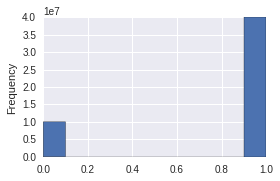

In [25]:
network.cross_species.plot.hist()

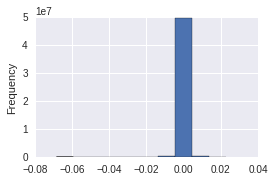

In [26]:
network.pcor.plot.hist()

In [27]:
locus_to_organism = pd.read_csv('/dacb/meta4_bins/data/genome_bins.locus_to_organism.tsv', sep='\t',
                               names=['locus', 'organism'])

In [28]:
locus_to_organism.head()

,locus,organism
0,Ga0081607_1001,Methylobacter-123 (UID203)
1,Ga0081607_1002,Methylobacter-123 (UID203)
2,Ga0081607_1003,Methylobacter-123 (UID203)
3,Ga0081607_1004,Methylobacter-123 (UID203)
4,Ga0081607_1005,Methylobacter-123 (UID203)


In [29]:
# Found a problem: 
# Expected exactly 2 organsm names, but we have 3
#   {'Methylobacter-123 (UID203) ', 'Methylobacter-123 (UID203)', 'Methylotenera mobilis-49 (UID203)'}
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.strip.html
#   strips both left and right whitespace  :) 
locus_to_organism['organism'] = locus_to_organism['organism'].str.strip()

In [30]:
locus_to_organism['organism ID'] = locus_to_organism['locus'].str.extract('([A-z]+[0-9]+)_[0-9]+')

In [31]:
source_organism_names = locus_to_organism[['organism ID', 'organism']].drop_duplicates()
target_organism_names = locus_to_organism[['organism ID', 'organism']].drop_duplicates()

In [32]:
source_organism_names = source_organism_names.rename(
    columns={'organism ID':'source_organism', 'organism':'source_organism_name'})
target_organism_names = target_organism_names.rename(
    columns={'organism ID':'target_organism', 'organism':'target_organism_name'})

In [33]:
source_organism_names

,source_organism,source_organism_name
0,Ga0081607,Methylobacter-123 (UID203)
260,Ga0081608,Methylotenera mobilis-123 (UID3888)
560,Ga0081609,Acidovorax-123 (UID4000)
578,Ga0081610,Rhodocyclaceae-127 (UID3972)
938,Ga0081611,Methylophilus methylotrophus-127-1 (UID203)
1080,Ga0081612,Methylophilus methylotrophus-127-2 (UID203)
1307,Ga0081613,Acidovorax-127 (UID4105)
1367,Ga0081614,Methylobacter tundripaludum-129 (UID203)
1454,Ga0081615,Opitutae-129 (UID2982)
1647,Ga0081616,Burkholderiales-129 (UID4000)


In [34]:
merged = pd.merge(network, source_organism_names)

In [35]:
len(merged.source_organism_name.unique())

51

In [36]:
merged.head(2)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203)
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203)


In [37]:
merged = pd.merge(merged, target_organism_names)
print(merged.shape)
print(network.shape)

(49995000, 11)
(49995000, 9)


In [38]:
merged.head()

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)
2,Ga0081614_142199,Ga0081614_18334,-0.001114,negative,Ga0081614,18334,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)
3,Ga0081614_142199,Ga0081614_17829,-0.001569,negative,Ga0081614,17829,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)
4,Ga0081614_142199,Ga0081614_142153,-0.001388,negative,Ga0081614,142153,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)


In [39]:
len(merged.target_organism_name.unique())

51

In [40]:
print(merged.shape)
print(network.shape)

merged.tail(3)

(49995000, 11)
(49995000, 9)


,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
49994997,Ga0081619_12132,Ga0081639_16605,0.005073,positive,Ga0081639,16605,Ga0081619,12132,True,Bacteriovorax-21 (UID3187),Bacteriovorax-63 (UID3187)
49994998,Ga0081619_1266,Ga0081639_16605,0.001305,positive,Ga0081639,16605,Ga0081619,1266,True,Bacteriovorax-21 (UID3187),Bacteriovorax-63 (UID3187)
49994999,Ga0081650_1031,Ga0081639_16605,-0.007078,negative,Ga0081639,16605,Ga0081650,1031,True,Methylophilus methylotrophus-79 (UID3888),Bacteriovorax-63 (UID3187)


**Use summary_counts, not summary_rpkm for gene names.**

`jmatsen@waffle:/dacb/meta4_bins/analysis/assemble_summaries$ ag Ga0081607_11219 summary_rpkm.xls | head -n 10
jmatsen@waffle:/dacb/meta4_bins/analysis/assemble_summaries$ ag Ga0081607_11219 summary_counts.xls | head -n 10
2015:Methylobacter-123 (UID203)         Ga0081607_11219 hypothetical protein    243652  6660    160     285587  448     89      94      4893    13
        66994   47733   163     301     3       146     1851    26      53125   249288  21      14249   28      12      42296   23538   2778    1918      2061    217     173983  164307  398     450     1170    10410   30      344     2224    2164    1452    810     338     656     70      222       3475    1143    2672    1313    1246    930     54      23      9942    9603    2381    8196    29      49      23721   7808    33195   17291     5825    6609    36      83      40661   28629   17949   12227   15478   15054   125     1010    10214   66875   40225   944     11993   9572      56      9375`

In [41]:
genes = pd.read_csv('/dacb/meta4_bins/analysis/assemble_summaries/summary_counts.xls', 
                    sep = '\t', usecols=[1, 2])

In [42]:
genes.tail(3)

,locus_tag,product
169834,Ga0081655_13359,sulfur compound chelating protein SoxZ
169835,Ga0081655_133510,thiosulfate-binding protein SoxY
169836,Ga0081655_133511,predicted Zn-dependent protease


In [43]:
genes.tail()

,locus_tag,product
169832,Ga0081655_13357,alkyl hydroperoxide reductase subunit F
169833,Ga0081655_13358,peroxiredoxin (alkyl hydroperoxide reductase s...
169834,Ga0081655_13359,sulfur compound chelating protein SoxZ
169835,Ga0081655_133510,thiosulfate-binding protein SoxY
169836,Ga0081655_133511,predicted Zn-dependent protease


In [44]:
genes[genes['locus_tag'] == 'Ga0081607_11219']

,locus_tag,product
2013,Ga0081607_11219,hypothetical protein


In [45]:
merged.head(2)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203)


In [46]:
source_genes = genes[['locus_tag', 'product']].rename(
    columns={'locus_tag':'source_locus_tag', 'product':'source_gene_product'})
target_genes = genes[['locus_tag', 'product']].rename(
    columns={'locus_tag':'target_locus_tag', 'product':'target_gene_product'})

In [47]:
source_genes.head(2)

,source_locus_tag,source_gene_product
0,Ga0081607_10011,"DNA gyrase B subunit, carboxyl terminus"
1,Ga0081607_10012,Putative addiction module component


In [48]:
network.shape

(49995000, 9)

In [49]:
merged.shape

(49995000, 11)

In [50]:
merged = pd.merge(merged, source_genes)

In [51]:
merged.shape

(49995000, 12)

In [52]:
merged = pd.merge(merged, target_genes)

In [53]:
merged.shape

(49995000, 13)

In [54]:
merged.head(2)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203),methane/ammonia monooxygenase subunit C,methane/ammonia monooxygenase subunit B
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203),methane/ammonia monooxygenase subunit C,methane/ammonia monooxygenase subunit A


In [55]:
merged.head(3)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
0,Ga0081614_142199,Ga0081614_142197,-0.003951,negative,Ga0081614,142197,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203),methane/ammonia monooxygenase subunit C,methane/ammonia monooxygenase subunit B
1,Ga0081614_142199,Ga0081614_142198,-0.003919,negative,Ga0081614,142198,Ga0081614,142199,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203),methane/ammonia monooxygenase subunit C,methane/ammonia monooxygenase subunit A
2,Ga0081614_142197,Ga0081614_142198,-0.004303,negative,Ga0081614,142198,Ga0081614,142197,False,Methylobacter tundripaludum-129 (UID203),Methylobacter tundripaludum-129 (UID203),methane/ammonia monooxygenase subunit B,methane/ammonia monooxygenase subunit A


In [56]:
merged['sort'] = merged.pcor.abs()
merged = merged.sort(columns='sort', ascending=False).drop('sort', axis=1)

/home/jmatsen/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [57]:
merged['pcor'].describe()

count    49995000.000000
mean           -0.000126
std             0.001239
min            -0.068416
25%            -0.000743
50%            -0.000087
75%             0.000535
max             0.022518
Name: pcor, dtype: float64

In [58]:
merged.head(2)

,source_locus_tag,target_locus_tag,pcor,association,target_organism,target_gene,source_organism,source_gene,cross_species,source_organism_name,target_organism_name,source_gene_product,target_gene_product
41680115,Ga0081622_103612,Ga0081637_12071,-0.068416,negative,Ga0081637,12071,Ga0081622,103612,True,Methylosarcina-21 (UID203),Methylophilaceae-55 (UID3888),amino acid adenylation enzyme/thioester reduct...,acyl-CoA synthetase/AMP-acid ligase
39909105,Ga0081646_101747,Ga0081622_103612,-0.066745,negative,Ga0081622,103612,Ga0081646,101747,True,Bacteroidetes-76 (UID2591),Methylosarcina-21 (UID203),phosphoribosylaminoimidazolecarboxamide formyl...,amino acid adenylation enzyme/thioester reduct...


In [59]:
filename = '50M_network'

In [60]:
! ls ../data

50M_network		      network_broken_20.csv  network.txt
gene_names.tsv		      network_broken.csv     network_with_info.txt
Methylobacter--Methylotenera  network_broken.tsv


In [61]:
dirname = '../data/50M_network/' 

In [62]:
if not os.path.exists(dirname):
    print"make dir {}".format(dirname)
    os.mkdir(dirname)
else:
    print("dir {} already exists.".format(dirname))

dir ../data/50M_network/ already exists.


In [63]:
path = dirname + filename + '.tsv'
print('save to : {}'.format(path))
merged.to_csv(path, sep='\t', index=False)

save to : ../data/50M_network/50M_network.tsv


In [64]:
# The CSV isn't a good idea because of the gene names. 
#merged.to_csv(dirname + filename + '.csv')

In [65]:
merged.head(100).to_csv(dirname + filename + '--100' + '.tsv', sep='\t', index=False)

In [66]:
os.listdir(dirname)

['50M_network.tsv', '50M_network--100.tsv']

In [67]:
merged.shape

(49995000, 13)